In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
data_Bank=pd.read_csv("/kaggle/input/ecommerce-data/data.csv", encoding='ISO-8859-1')

In [3]:
data_Bank.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [4]:
data_Bank.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
data_Bank.shape

(541909, 8)

In [6]:
data_Bank=data_Bank.dropna()

In [7]:
data_Bank.shape

(406829, 8)

In [8]:
data_Bank.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:

# Calculate IQR for Quantity
Q1_quantity = data_Bank['Quantity'].quantile(0.25)
Q3_quantity = data_Bank['Quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity

# Calculate IQR for UnitPrice
Q1_unit_price = data_Bank['UnitPrice'].quantile(0.25)
Q3_unit_price = data_Bank['UnitPrice'].quantile(0.75)
IQR_unit_price = Q3_unit_price - Q1_unit_price

# Define the upper and lower bounds for outliers
lower_bound_quantity = Q1_quantity - 1.5 * IQR_quantity
upper_bound_quantity = Q3_quantity + 1.5 * IQR_quantity

lower_bound_unit_price = Q1_unit_price - 1.5 * IQR_unit_price
upper_bound_unit_price = Q3_unit_price + 1.5 * IQR_unit_price

# Remove outliers
data_filtered = data_Bank[
    (data_Bank['Quantity'] >= lower_bound_quantity) & (data_Bank['Quantity'] <= upper_bound_quantity) &
    (data_Bank['UnitPrice'] >= lower_bound_unit_price) & (data_Bank['UnitPrice'] <= upper_bound_unit_price)
]

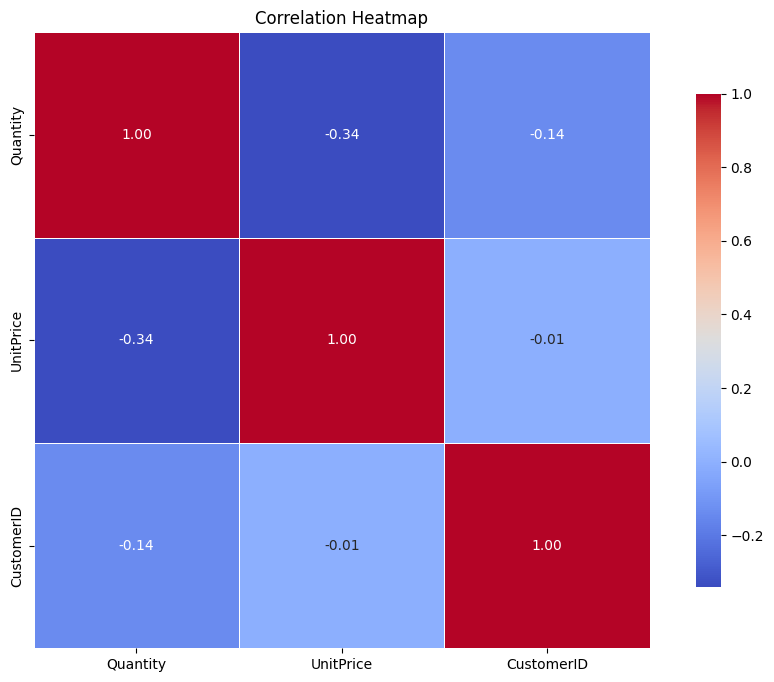

In [10]:
# Visualize relationships between variables
numeric_data = data_filtered.select_dtypes(include='number')
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", square=True, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap')
plt.show()

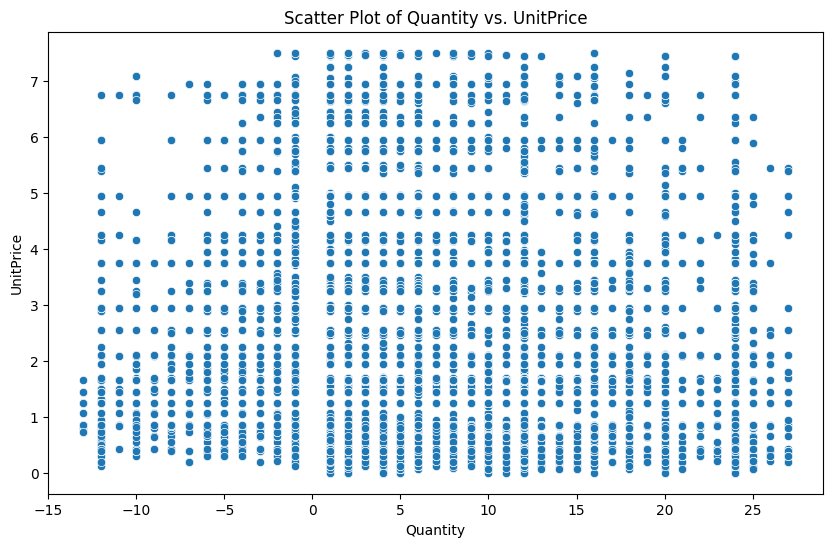

In [11]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quantity', y='UnitPrice', data=data_filtered)
plt.title('Scatter Plot of Quantity vs. UnitPrice')
plt.show()

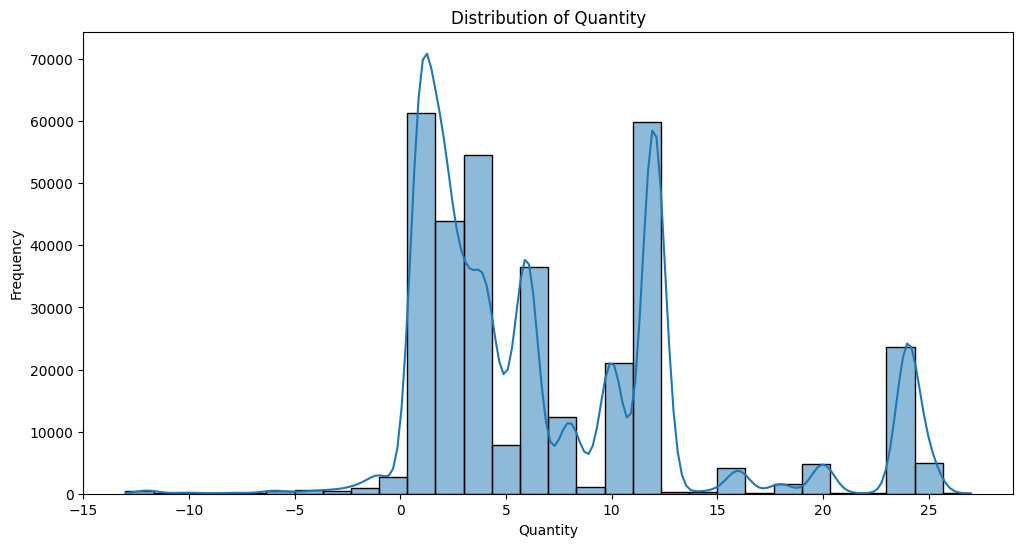

In [12]:
# Histogram for 'Quantity'
plt.figure(figsize=(12, 6))
sns.histplot(data_filtered['Quantity'], bins=30, kde=True)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

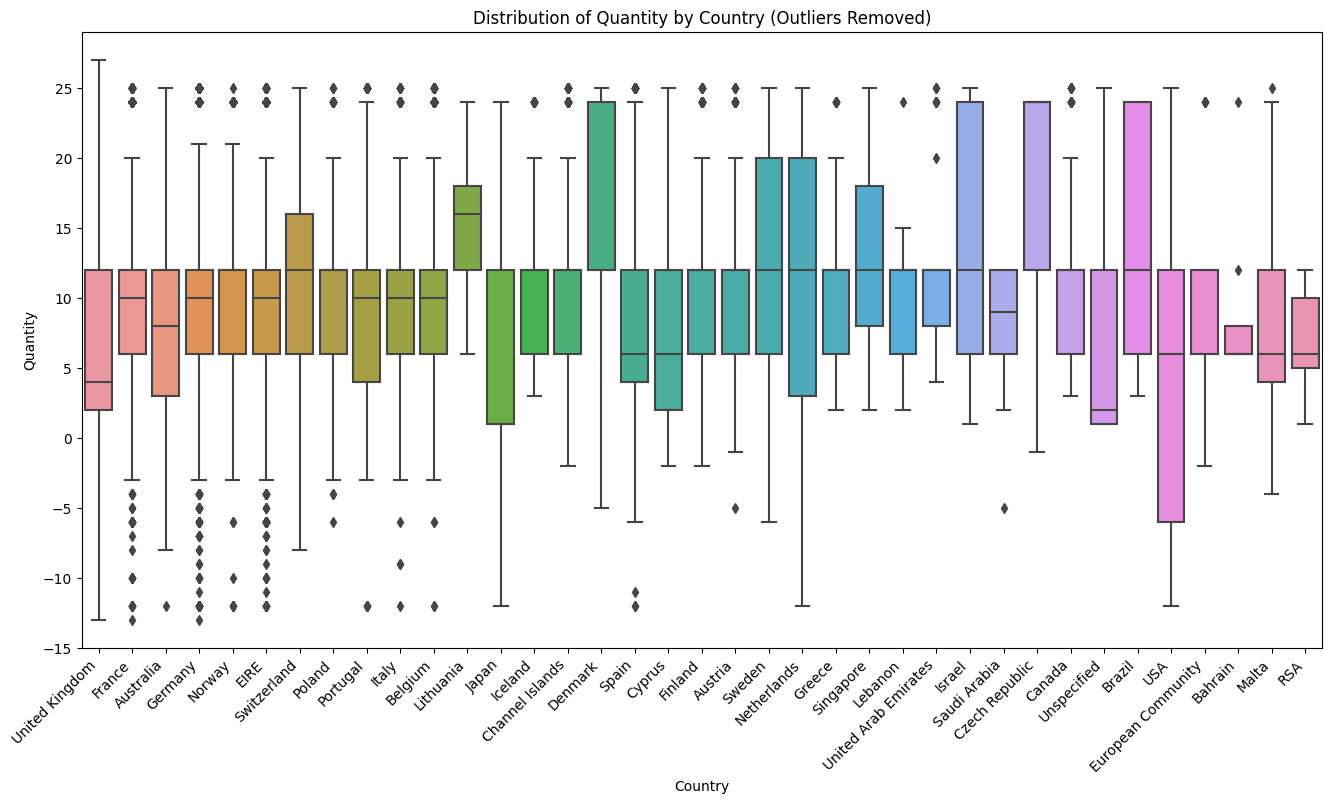

In [13]:
# Boxplot for 'Quantity' by 'Country'
plt.figure(figsize=(16, 8))
sns.boxplot(x='Country', y='Quantity', data=data_filtered)
plt.title('Distribution of Quantity by Country (Outliers Removed)')
plt.xlabel('Country')
plt.ylabel('Quantity')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

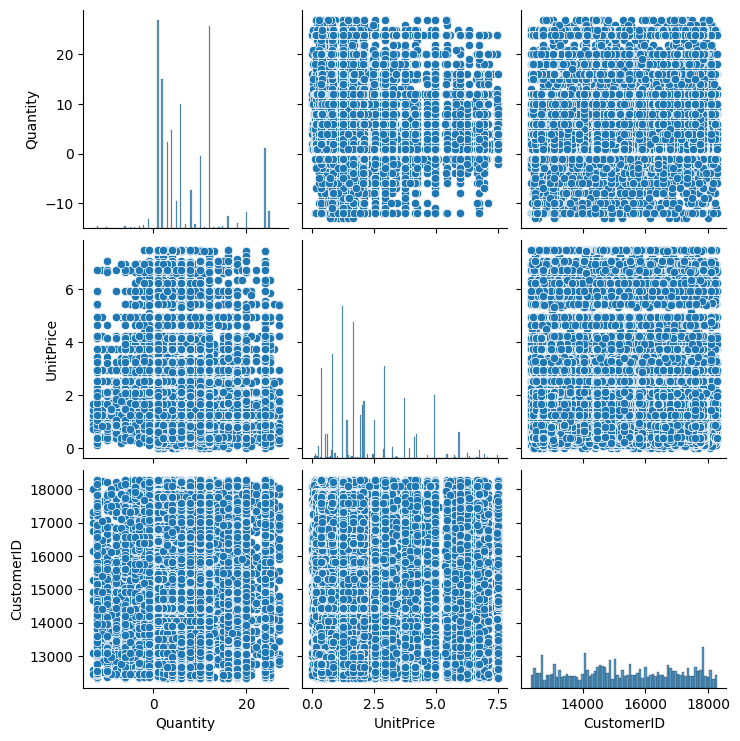

In [14]:
sns.pairplot(data_filtered)

In [15]:
sampled_data = data_filtered.sample(frac=0.1, random_state=42)

In [16]:
X = sampled_data.drop('UnitPrice', axis=1)
y = sampled_data['UnitPrice']

# Convert categorical variables to one-hot encoding (if needed)
X = pd.get_dummies(X, sparse=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network
model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(1)  # Output layer, no activation function for regression
])

model.compile(optimizer='adam', loss='mean_squared_error')  # Use mean squared error for regression

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Epoch 1/10
861/861 [==============================] - 17s 19ms/step - loss: 16.2328 - val_loss: 3.1072
Epoch 2/10
861/861 [==============================] - 10s 12ms/step - loss: 0.9322 - val_loss: 1.4147
Epoch 3/10
861/861 [==============================] - 10s 12ms/step - loss: 0.3432 - val_loss: 1.1559
Epoch 4/10
861/861 [==============================] - 9s 11ms/step - loss: 0.2030 - val_loss: 1.0533
Epoch 5/10
861/861 [==============================] - 10s 12ms/step - loss: 0.1646 - val_loss: 0.9022
Epoch 6/10
861/861 [==============================] - 10s 11ms/step - loss: 0.1516 - val_loss: 0.8344
Epoch 7/10
861/861 [==============================] - 9s 11ms/step - loss: 0.1331 - val_loss: 0.7717
Epoch 8/10
861/861 [==============================] - 10s 12ms/step - loss: 0.1170 - val_loss: 0.7465
Epoch 9/10
861/861 [==============================] - 10s 12ms/step - loss: 0.1075 - val_loss: 0.6814
Epoch 10/10
861/861 [==============================] - 9s 11ms/step - loss: 0.1069 

216/216 [==============================] - 1s 3ms/step


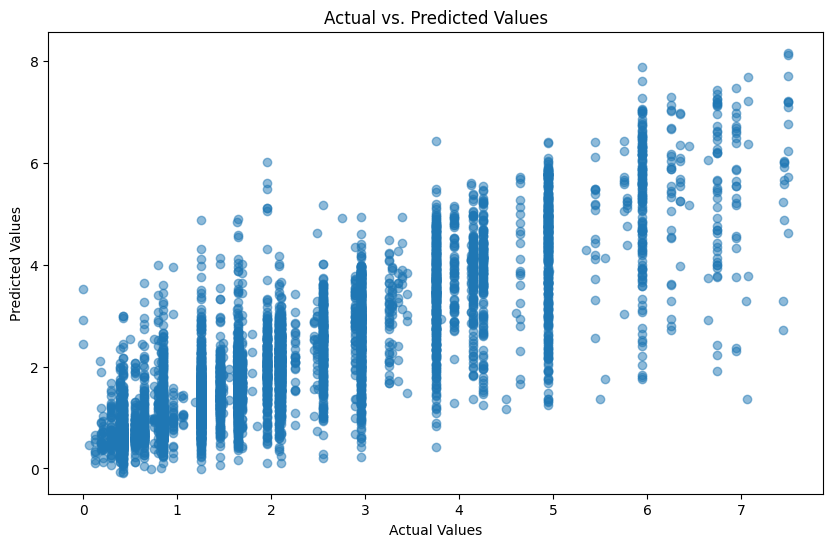

Mean Absolute Error (MAE): 0.53
Mean Squared Error (MSE): 0.64
Root Mean Squared Error (RMSE): 0.80


In [19]:

# Assuming you have already trained and predicted with your model
y_pred = model.predict(X_test_scaled)

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Calculate and print accuracy metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')